In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Documents/Johns Hopkins University/Classes/Spring 2023/EN.601.661 Computer Vision/project/hand-gesture-recognition-cpu"

/content/drive/MyDrive/Documents/Johns Hopkins University/Classes/Spring 2023/EN.601.661 Computer Vision/project/hand-gesture-recognition-cpu


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# Opening H5 file
import h5py # https://www.h5py.org

training_data = h5py.File("./datasets/Signs_Data_Training.h5", "r")
training_data

<HDF5 file "Signs_Data_Training.h5" (mode r)>

In [5]:
training_data.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [6]:
# X_train = np.array(training_data['train_set_x'])
# y_train = np.array(training_data['train_set_y'])

train_data = np.array(training_data['train_set_x'])
train_labels = np.array(training_data['train_set_y'])
print("Train data shape: ", train_data.shape)

Train data shape:  (1080, 64, 64, 3)


#### 1080 photos of 64x64 size, 3 colors

### Transpose data into the format Torch wants - (n_channels, width, height)
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [7]:
# https://numpy.org/doc/stable/reference/generated/numpy.transpose.html

train_data = np.transpose(train_data, axes=(0, 3, 1, 2))


train_data.shape

(1080, 3, 64, 64)

In [8]:
import torch

# Taken from Yann's paper
class LeNet5(torch.nn.Module):
    def __init__(self, input_height, input_width, n_classes):
        super().__init__()

        # C1. Put padding bcs MNIST had 32x32 data. We have 28x28
        self.C1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)

        # S2
        self.S2 = torch.nn.AvgPool2d(kernel_size=2)

        # C3
        self.C3 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # S4
        self.S4 = torch.nn.AvgPool2d(kernel_size=4) # Edited this due to our data being 64x64

        # C5
        self.C5 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=7) # Edited this due to our data being 64x64

        # F6
        self.F6 = torch.nn.Linear(in_features= 120, out_features=84)
        # self.layer4 = torch.nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1)

        # F7
        self.F7 = torch.nn.Linear(in_features= 84, out_features=n_classes)

        
    
    def forward(self, x):
        
        ### forward pass module
        # x = torch.unsqueeze(x, 1)

        ### feed forward function
        # print("x.shape: ", x.shape)
        
        # PyTorch expects (Batch_size, channel_nr, width, height)
        
        l1out = self.C1(x)
        l1out = torch.nn.Tanh()(l1out)
        
        # print("l1out.shape: After C1 and TanH", l1out.shape)

        # AvgPooling
        l2out = self.S2(l1out)
        
        # print("l2out.shape: after AvgPooling ", l2out.shape)

        l3out = self.C3(l2out)
        l3out = torch.nn.Tanh()(l3out)
        
        # print("l3out.shape: After C3 and TanH", l3out.shape)

        # AvgPooling
        l4out = self.S4(l3out)
        
        # print("l4out.shape, After Avg Pooling: ", l4out.shape)

        l5out = self.C5(l4out)
        l5out = torch.nn.Tanh()(l5out)

        l5out = np.squeeze(l5out)
        l5out = torch.nn.Dropout(.5)(l5out)
        
        # print("l5out.shape: after C5 and Tanh: ", l5out.shape)

        l6out = self.F6(l5out) # squeeze bcs (120,1) vector to (120,) - a numpy broadcast thing
        l6out = torch.nn.Tanh()(l6out)
        
        # print("l6out.shape: after F6 and squeeze ", l6out.shape)
        
        l7out = self.F7(l6out)
        
        # print("l7out.shape: After F7 ", l7out.shape)

        return l7out

## Split Train into Train and Dev. Test set is in another HDF5 file

In [9]:
# Create Cross-Validation/Dev set
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [10]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

X_train.shape:  (864, 3, 64, 64)
y_train.shape:  (864,)


In [11]:
MODE = "train"

In [12]:
# https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c

# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

False
False


In [13]:
# torch.device("mps") # Disable this if not on apple silicon!

In [14]:
import datetime
from utils.accuracies import dev_acc_and_loss, approx_train_acc_and_loss
import torch.nn.functional as F

# Modified From Ariel's EN.601.675 HW3
        
LOG_DIR = "."
MODEL_SAVE_DIR = "."
LEARNING_RATE = 0.0004 #arguments.get('lr')
BATCH_SIZE = 100 # 250 #arguments.get('bs')
EPOCHS = 2000 # arguments.get('epochs')
DATE_PREFIX = datetime.datetime.now().strftime('%Y%m%d%H%M')


TRAIN_IMAGES = X_train
TRAIN_LABELS = y_train
DEV_IMAGES = X_dev
DEV_LABELS = y_dev

### format dataset to the appropriate shape/dimensions necessary to be input into the model


n_train_imgs = TRAIN_IMAGES.shape[0]
HEIGHT = TRAIN_IMAGES.shape[1]
WIDTH = TRAIN_IMAGES.shape[2]
#  this will not be correct if not all classes are present in training
#   But if classes are entirely missing from training, we cannot possibly hope to do well on them
N_CLASSES = len(np.unique(TRAIN_LABELS))
# raise NotImplementedError

### Normalize 
train_imgs = (TRAIN_IMAGES - np.mean(TRAIN_IMAGES))/ np.std(TRAIN_IMAGES)
dev_imgs = (DEV_IMAGES - np.mean(DEV_IMAGES))/ np.std(DEV_IMAGES)

### change depending on your model's instantiation

model = LeNet5(input_height = HEIGHT, input_width= WIDTH,
                  n_classes=N_CLASSES)


### (OPTIONAL) : you can change the choice of optimizer here if you wish.
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

train_acc_col = []
train_loss_col = []
dev_acc_col = []
dev_loss_col = []
steps_col = []
for step in range(EPOCHS):
    i = np.random.choice(train_imgs.shape[0], size=BATCH_SIZE, replace=False)
    x = torch.from_numpy(np.squeeze(train_imgs[i]).astype(np.float32))
    y = torch.from_numpy(np.squeeze(TRAIN_LABELS[i].astype(int)))


    # Forward pass: Get logits for x
    logits = model(x)
    # Compute loss
    loss = F.cross_entropy(logits, y)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Here for more granular plots
    train_acc, train_loss = approx_train_acc_and_loss(model, train_imgs, TRAIN_LABELS)
    dev_acc, dev_loss = dev_acc_and_loss(model, dev_imgs, DEV_LABELS)
    
    train_acc_col.append(train_acc)
    train_loss_col.append(train_loss)
    dev_acc_col.append(dev_acc)
    dev_loss_col.append(dev_loss)
    steps_col.append(step)

    # log model performance every 100 epochs
    if step % 100 == 0:
        step_metrics = {
            'step': step, 
            'train_loss': loss.item(), 
            'train_acc': train_acc,
            'dev_loss': dev_loss,
            'dev_acc': dev_acc
        }

        print(f"On step {step}:\tTrain loss {train_loss}\t|\tDev acc is {dev_acc}")
        # logger.writerow(step_metrics)
# LOGFILE.close()

# Save model
model_savepath = os.path.join(MODEL_SAVE_DIR,f"{DATE_PREFIX}_bestmodel.pt")


print("Training completed, saving model at {model_savepath}")
torch.save(model, model_savepath)

On step 0:	Train loss 1.7811691761016846	|	Dev acc is 0.18055555555555555
On step 100:	Train loss 0.9681639671325684	|	Dev acc is 0.6944444444444444
On step 200:	Train loss 0.49415045976638794	|	Dev acc is 0.8009259259259259
On step 300:	Train loss 0.2658335268497467	|	Dev acc is 0.8379629629629629
On step 400:	Train loss 0.15584023296833038	|	Dev acc is 0.8703703703703703
On step 500:	Train loss 0.11961755901575089	|	Dev acc is 0.9120370370370371
On step 600:	Train loss 0.07776419818401337	|	Dev acc is 0.8796296296296297
On step 700:	Train loss 0.05869033932685852	|	Dev acc is 0.875
On step 800:	Train loss 0.0387997068464756	|	Dev acc is 0.9074074074074074
On step 900:	Train loss 0.01944088749587536	|	Dev acc is 0.9074074074074074
On step 1000:	Train loss 0.02489449828863144	|	Dev acc is 0.9166666666666666
On step 1100:	Train loss 0.012965935282409191	|	Dev acc is 0.8935185185185185
On step 1200:	Train loss 0.010627035051584244	|	Dev acc is 0.9074074074074074
On step 1300:	Train loss 

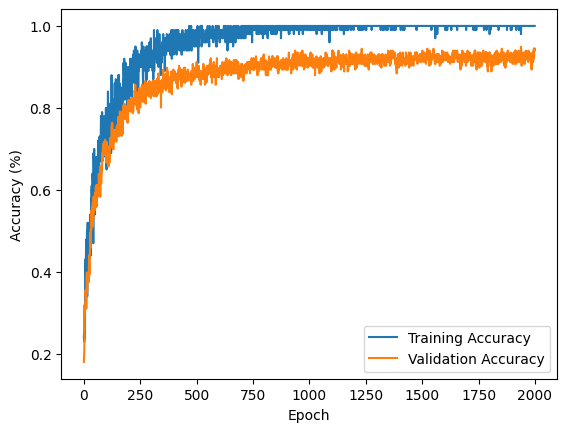

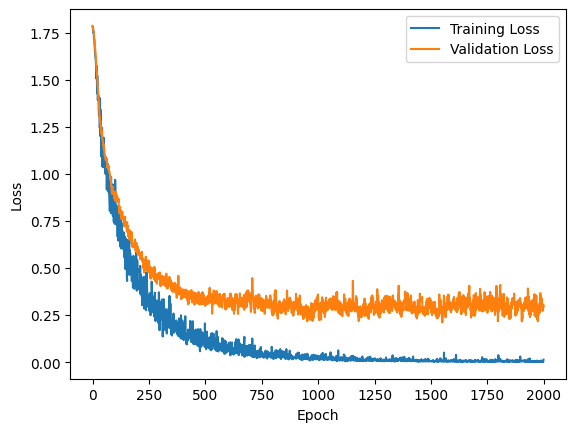

Final Stats:	Train loss 0.01320265419781208	|	Validation Loss 0.2957391142845154	|	Train acc is 1.0 	|	Dev acc is 0.9444444444444444


In [15]:
from matplotlib import pyplot as plt

fig1 = plt.figure()
plt.plot(steps_col, train_acc_col, label = "Training Accuracy")
plt.plot(steps_col, dev_acc_col, label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()


fig2 = plt.figure()
plt.plot(steps_col, train_loss_col, label = "Training Loss")
plt.plot(steps_col, dev_loss_col, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print(f"Final Stats:\tTrain loss {train_loss_col[1999]}\t|\tValidation Loss {dev_loss_col[1999]}\t|\tTrain acc is {train_acc_col[1999]} \t|\tDev acc is {dev_acc_col[1999]}")
    

## Let's see performance on test set

In [16]:
test_data = h5py.File("./datasets/Signs_Data_Testing.h5", "r")
TEST_IMAGES = test_data["test_set_x"]
test_labels = test_data["test_set_y"] # Do not train on these!!

In [17]:
# Transpose into correct shape for PyTorch

TEST_IMAGES = np.transpose(TEST_IMAGES, axes=(0, 3, 1, 2))

In [18]:
TEST_IMAGES.shape

(120, 3, 64, 64)

In [19]:
# model = torch.load(WEIGHTS_FILE) # Load model parameters from file to avoid retraining

predictions = []
testSetMean = TEST_IMAGES.mean()
testSetStd = TEST_IMAGES.std()
for test_case in TEST_IMAGES:

    ### normalization schemes
    test_case = (test_case - testSetMean) / testSetStd

    # test_case = test_case.reshape(1,28,28)


    x = torch.from_numpy(test_case.astype(np.float32))
    # x = x.view(1,-1)
    logits = model(x)
    logits = logits.reshape(-1, 6)
    pred = torch.max(logits, 1)[1]
    predictions.append(pred.item())

predictions[:15] # First 15 predicted labels

[0, 0, 0, 4, 1, 0, 3, 1, 5, 1, 5, 1, 3, 1, 1]

In [20]:
from utils.accuracies import accuracy

print("Test accuracy: ", accuracy(np.array(predictions), np.array(test_labels)))

Test accuracy:  0.925


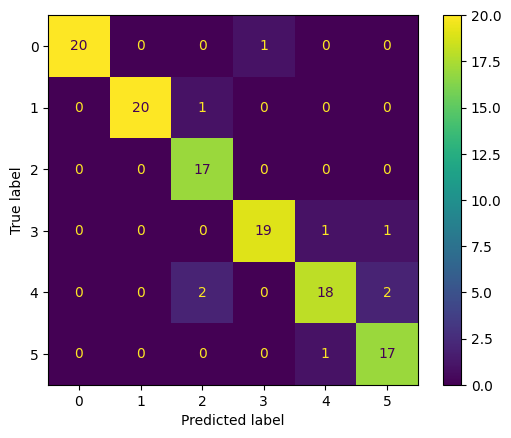

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf_matrix = confusion_matrix(predictions, test_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)#, display_labels=clf.classes_)

disp.plot()
plt.show()

## Albumentations

In [22]:
train_data = np.transpose(train_data, (0, 2,3,1)) # Images were (3,64,64)

In [23]:
import albumentations as A
import cv2

transform = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.ColorJitter(brightness= 0, contrast=(1, 1.5), saturation=(0.5,1), hue=0, p=1)
])

train_data2 = train_data.copy()
albumentationList = []
for num in range(3):
    for imageSet in train_data:
        merged = cv2.merge([np.array(imageSet[:,:,2]), np.array(imageSet[:,:,1]), np.array(imageSet[:,:,0])])
        image = cv2.cvtColor(merged, cv2.COLOR_BGR2RGB)
        image = transform(image=image)['image']
        # print(image.shape)
        # ch0, ch1, ch2 = cv2.split(image) # Why??
        # image = np.array([ch0, ch1, ch2])
        albumentationList.append(image)
    print(num, "done")
# albumentationList = [np.array(i).T for i in albumentationList]

0 done
1 done
2 done


In [24]:
albumentationList[0].shape

(64, 64, 3)

In [25]:
type(train_data[0])

numpy.ndarray

In [26]:
train_data.shape

(1080, 64, 64, 3)

<Figure size 640x480 with 0 Axes>

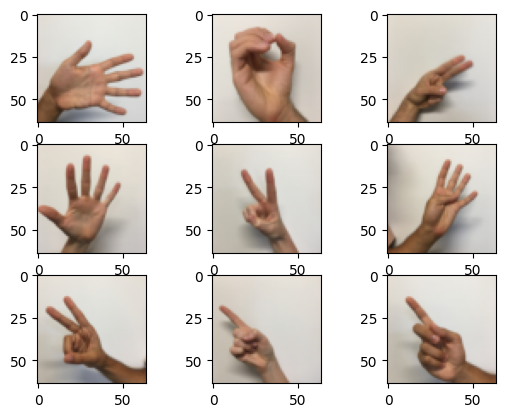

In [27]:
plt.figure()

a = 3
b = 3
fig, axis = plt.subplots(a,b)
for n in range(a):
    for m in range(b):
        num = a*n + m
        axis[n][m].imshow(np.reshape(train_data[num], (64,64,3)))
plt.show()

<Figure size 640x480 with 0 Axes>

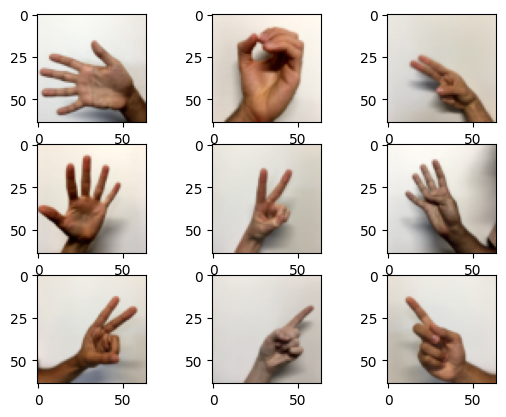

In [28]:
plt.figure()

a = 3
b = 3
fig, axis = plt.subplots(a,b)
for n in range(a):
    for m in range(b):
        num = a*n + m
        axis[n][m].imshow(albumentationList[num])
plt.show()

In [29]:
np.array(albumentationList).shape

(3240, 64, 64, 3)

In [30]:
np.array(train_data2).shape

(1080, 64, 64, 3)

In [31]:
train_data2 = np.append(train_data2, np.array(albumentationList), axis = 0)

#### Split Albumentated dataset into train-test

In [32]:
# Do not use np.repeat!
aug_labels = np.tile(train_labels, 4) # Labels are repeated in the albumentations. Assuming classes don't change

In [33]:
aug_labels[0:10]

array([5, 0, 2, 5, 2, 4, 2, 1, 1, 4])

In [34]:
train_data2 = torch.Tensor(train_data2).view(len(train_data2), 3, 64,64)

In [35]:
train_data2 = train_data2.to(torch.uint8)

In [36]:
# Create Cross-Validation/Dev set
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(train_data2, aug_labels, test_size=0.2, random_state=42)

In [ ]:
import datetime
from utils.accuracies import dev_acc_and_loss, approx_train_acc_and_loss
import torch.nn.functional as F

# Modified From Ariel's EN.601.675 HW3
        
LOG_DIR = "."
MODEL_SAVE_DIR = "."
LEARNING_RATE = 0.0004 #arguments.get('lr')
BATCH_SIZE = 100 # 250 #arguments.get('bs')
EPOCHS = 2000 # arguments.get('epochs')
DATE_PREFIX = datetime.datetime.now().strftime('%Y%m%d%H%M')


TRAIN_IMAGES = X_train.to(torch.float32)
TRAIN_LABELS = y_train
DEV_IMAGES = X_dev.to(torch.float32)
DEV_LABELS = y_dev

### format dataset to the appropriate shape/dimensions necessary to be input into the model


n_train_imgs = TRAIN_IMAGES.shape[0]
HEIGHT = TRAIN_IMAGES.shape[1]
WIDTH = TRAIN_IMAGES.shape[2]
#  this will not be correct if not all classes are present in training
#   But if classes are entirely missing from training, we cannot possibly hope to do well on them
N_CLASSES = len(np.unique(TRAIN_LABELS))
# raise NotImplementedError

### Normalize 
train_imgs = (TRAIN_IMAGES - torch.mean(TRAIN_IMAGES))/ torch.std(TRAIN_IMAGES)
dev_imgs = (DEV_IMAGES - torch.mean(DEV_IMAGES))/ torch.std(DEV_IMAGES)

### change depending on your model's instantiation

model = LeNet5(input_height = HEIGHT, input_width= WIDTH,
                  n_classes=N_CLASSES)


### (OPTIONAL) : you can change the choice of optimizer here if you wish.
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

train_acc_col = []
train_loss_col = []
dev_acc_col = []
dev_loss_col = []
steps_col = []
for step in range(EPOCHS):
    i = np.random.choice(train_imgs.shape[0], size=BATCH_SIZE, replace=False)
    # x = torch.from_numpy(np.squeeze(train_imgs[i]).astype(np.float32))
    x = train_imgs[i]
    y = torch.from_numpy(np.squeeze(TRAIN_LABELS[i]))#.astype(int)))


    # Forward pass: Get logits for x
    logits = model(x)
    # Compute loss
    loss = F.cross_entropy(logits, y)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Here for more granular plots
    train_acc, train_loss = approx_train_acc_and_loss(model, np.array(train_imgs), TRAIN_LABELS)
    dev_acc, dev_loss = dev_acc_and_loss(model, np.array(dev_imgs), DEV_LABELS)
    
    train_acc_col.append(train_acc)
    train_loss_col.append(train_loss)
    dev_acc_col.append(dev_acc)
    dev_loss_col.append(dev_loss)
    steps_col.append(step)

    # log model performance every 100 epochs
    if step % 100 == 0:
        step_metrics = {
            'step': step, 
            'train_loss': loss.item(), 
            'train_acc': train_acc,
            'dev_loss': dev_loss,
            'dev_acc': dev_acc
        }

        print(f"On step {step}:\tTrain loss {train_loss}\t|\tDev acc is {dev_acc}")
        # logger.writerow(step_metrics)
# LOGFILE.close()

# Save model
model_savepath = os.path.join(MODEL_SAVE_DIR,f"{DATE_PREFIX}_bestmodel.pt")


print("Training completed, saving model at {model_savepath}")
torch.save(model, model_savepath)

On step 0:	Train loss 1.8037256002426147	|	Dev acc is 0.16435185185185186
On step 100:	Train loss 1.0731825828552246	|	Dev acc is 0.59375
On step 200:	Train loss 0.9558975100517273	|	Dev acc is 0.6712962962962963
On step 300:	Train loss 0.6360523104667664	|	Dev acc is 0.7164351851851852
On step 400:	Train loss 0.832612156867981	|	Dev acc is 0.7268518518518519
